# Cognitive Load and Wearable Integration Analysis


## Dataset traversal discovery


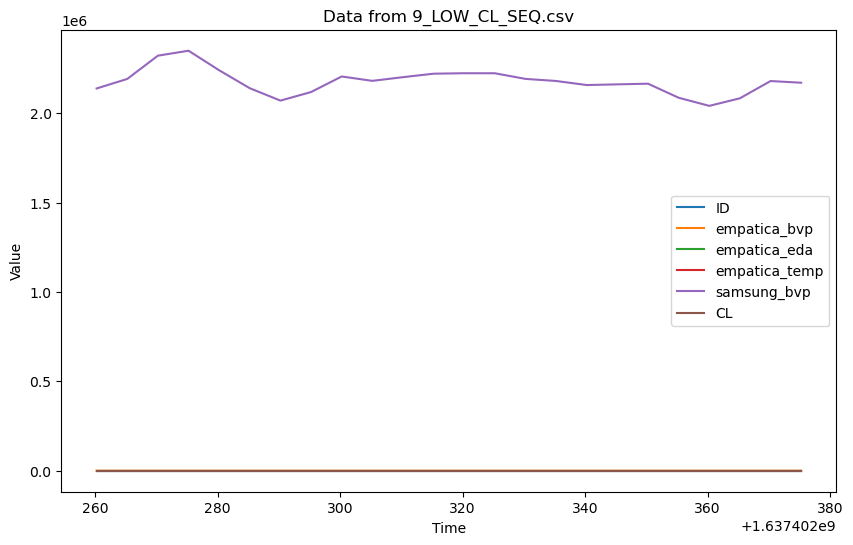

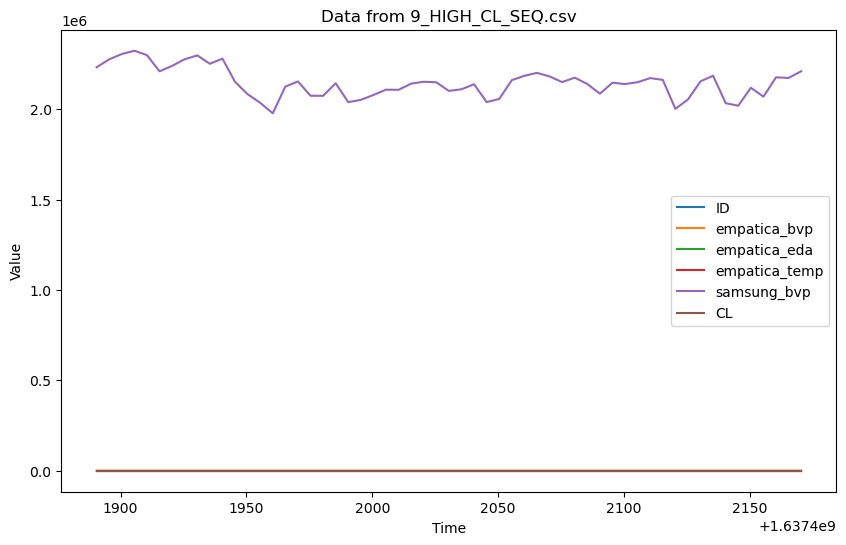

Error processing file ./data/participant-division/9/9_HIGH_CL.csv: 'time'
Error processing file ./data/participant-division/9/9_LOW_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

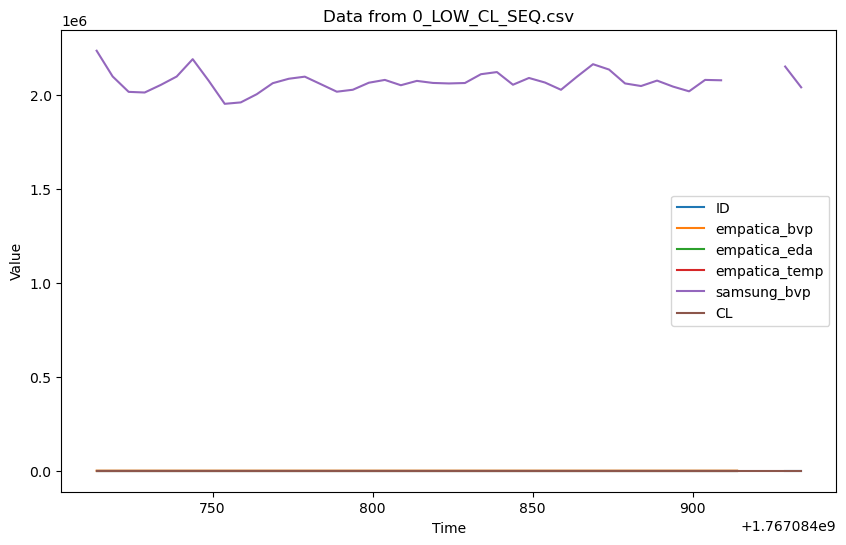

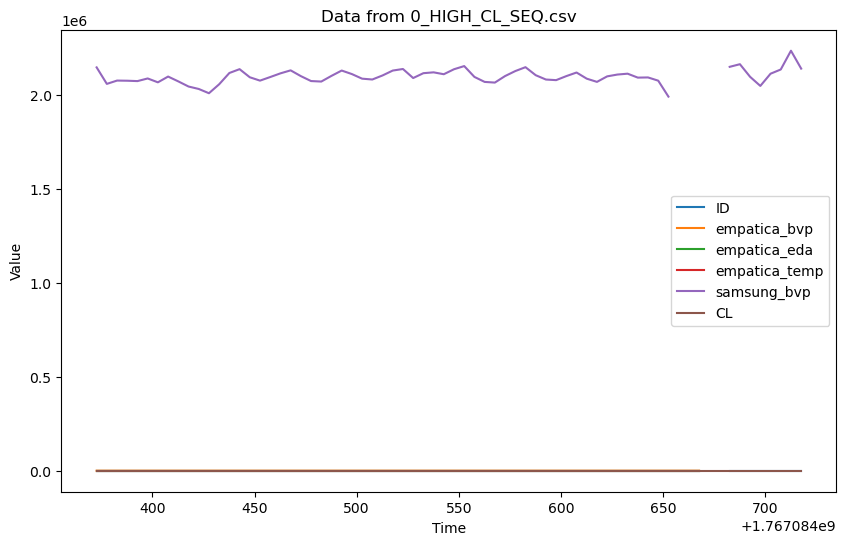

Error processing file ./data/participant-division/0/0_LOW_CL.csv: 'time'
Error processing file ./data/participant-division/0/0_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

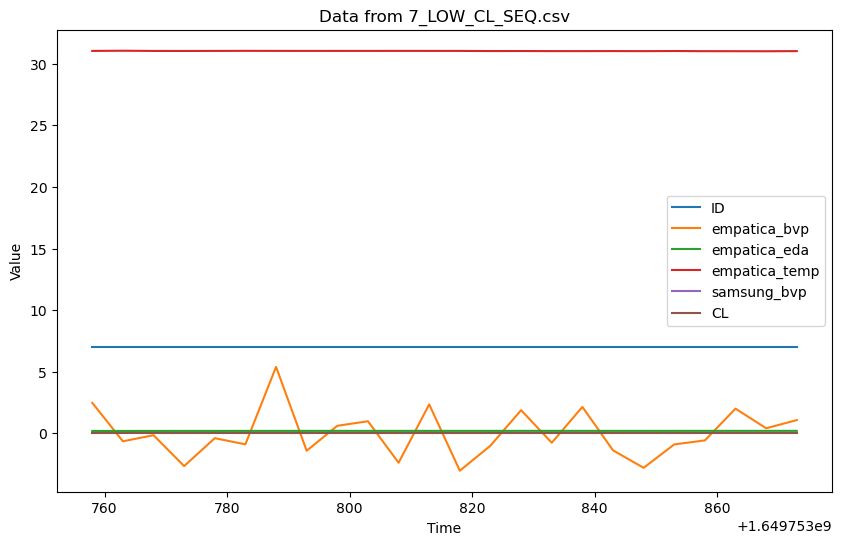

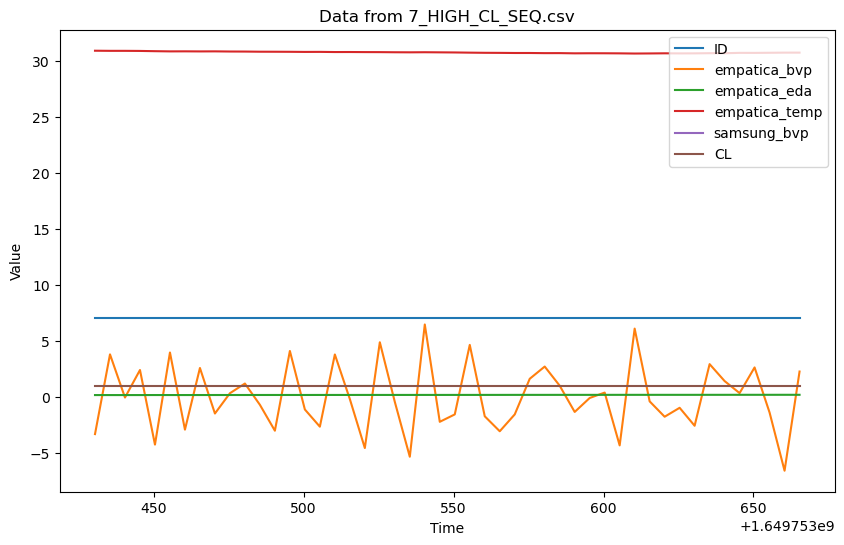

Error processing file ./data/participant-division/7/7_LOW_CL.csv: 'time'
Error processing file ./data/participant-division/7/7_HIGH_CL.csv: 'time'
Error processing file ./data/participant-division/6/6_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

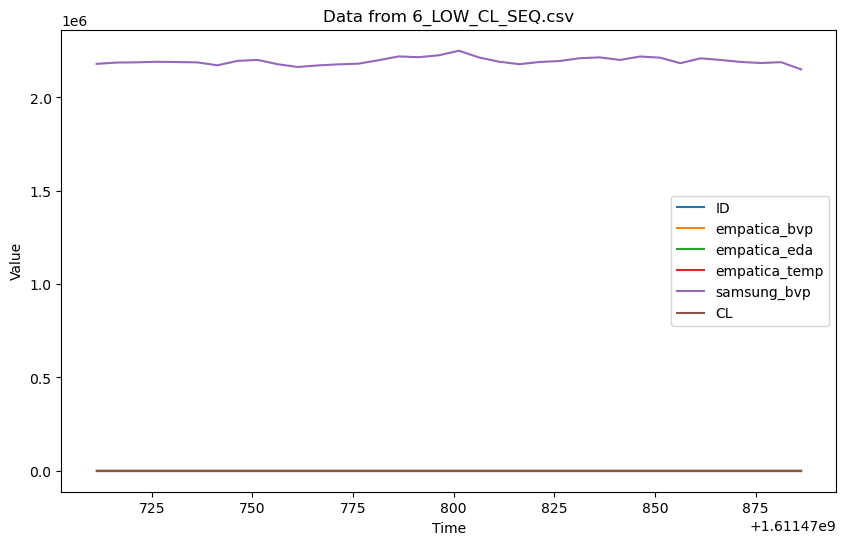

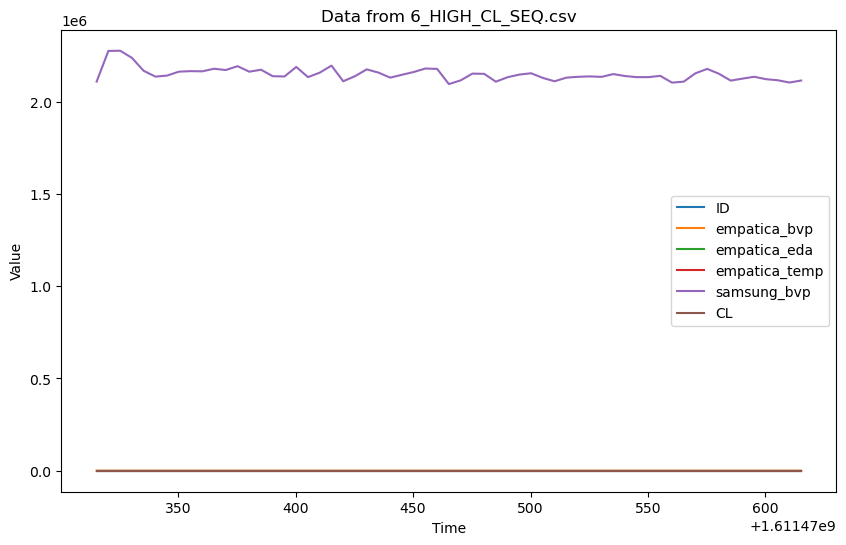

Error processing file ./data/participant-division/6/6_LOW_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

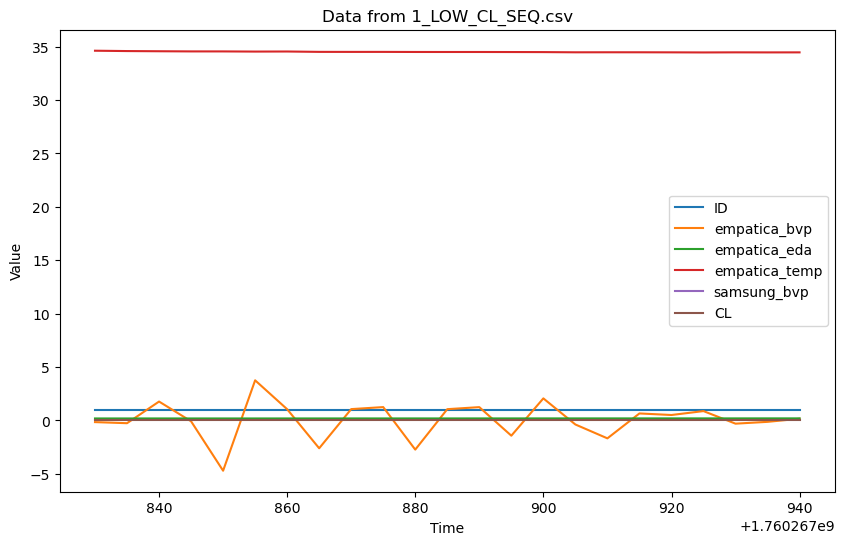

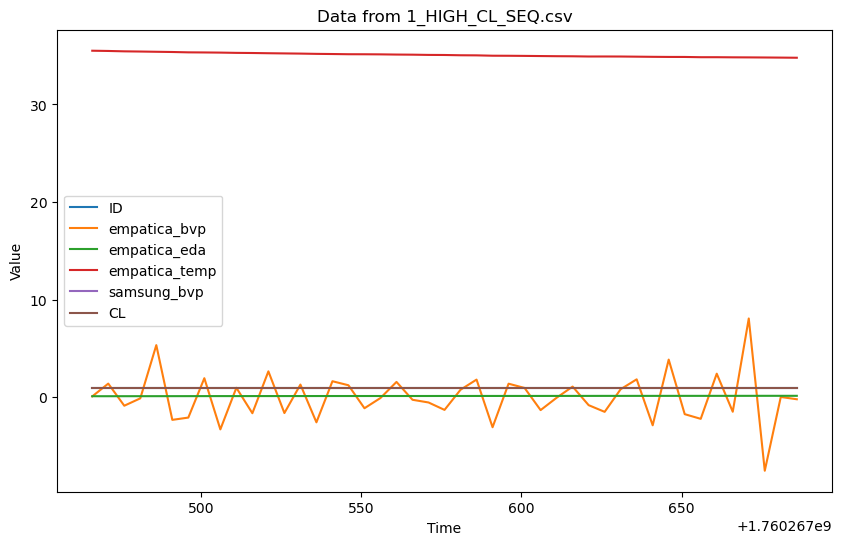

Error processing file ./data/participant-division/1/1_HIGH_CL.csv: 'time'
Error processing file ./data/participant-division/1/1_LOW_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

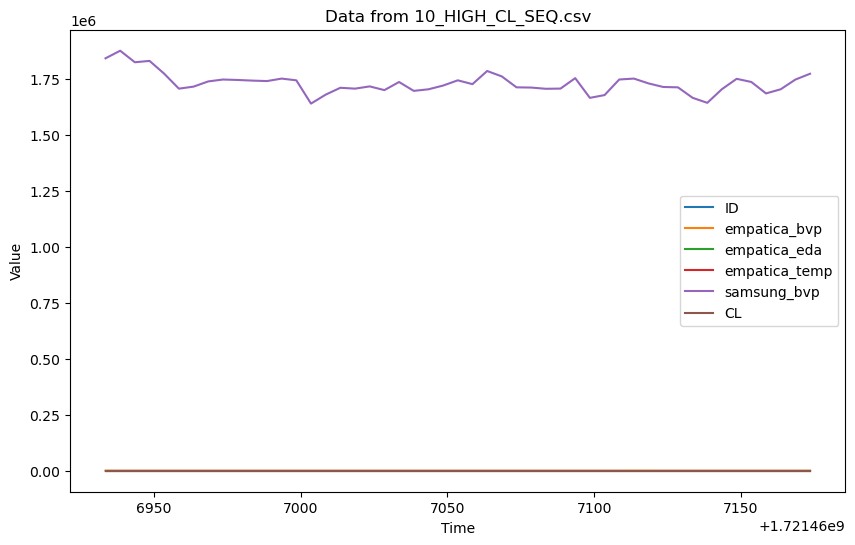

Error processing file ./data/participant-division/10/10_LOW_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

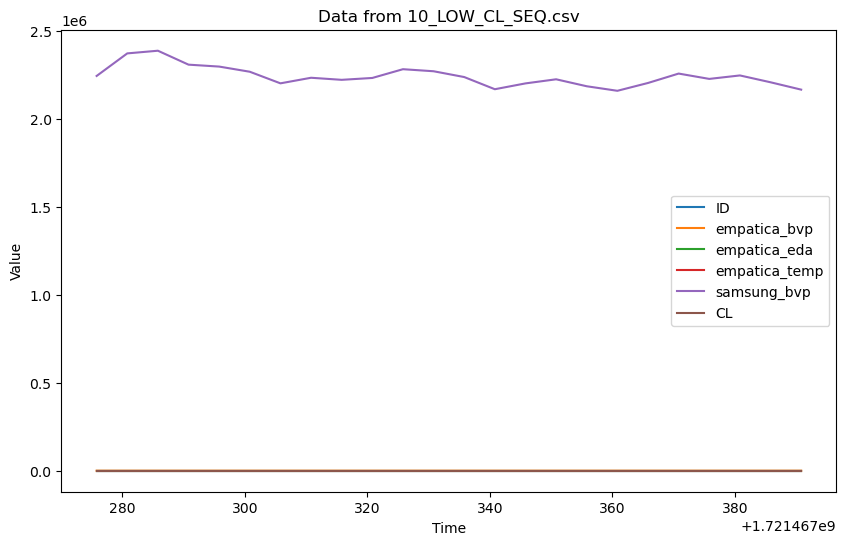

Error processing file ./data/participant-division/10/10_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

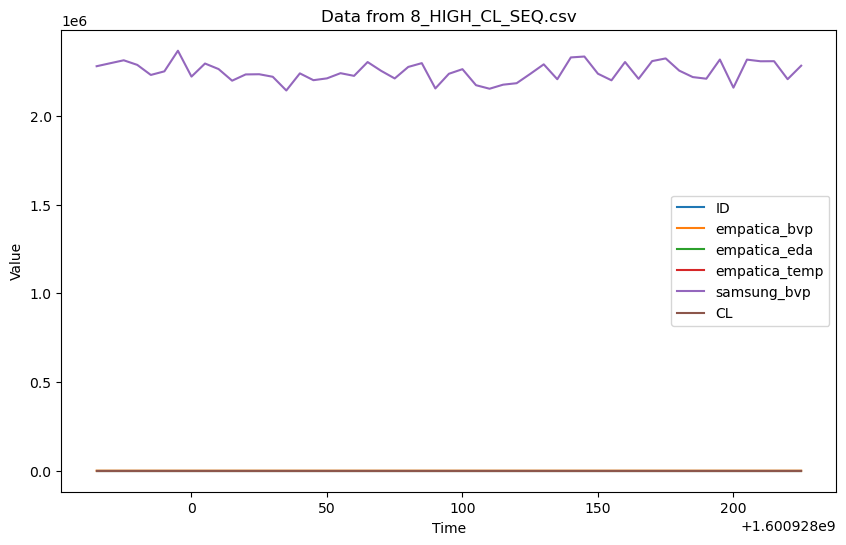

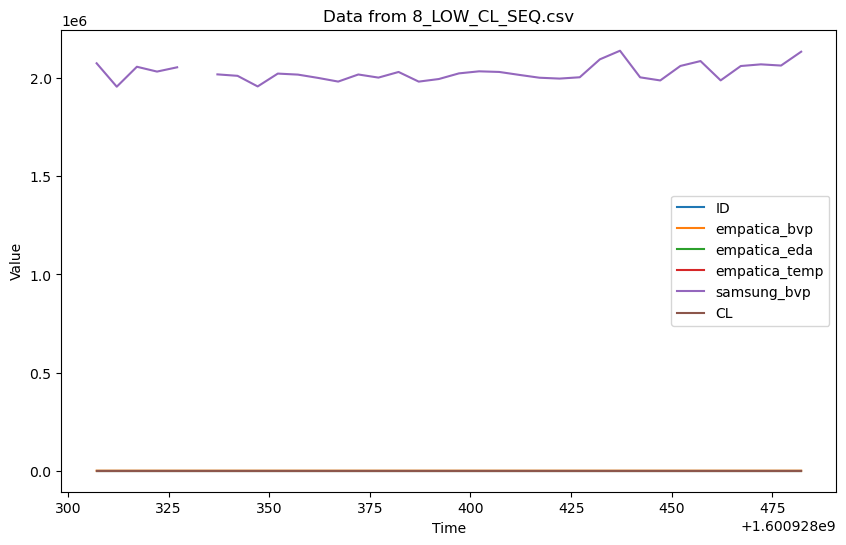

Error processing file ./data/participant-division/8/8_LOW_CL.csv: 'time'
Error processing file ./data/participant-division/8/8_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

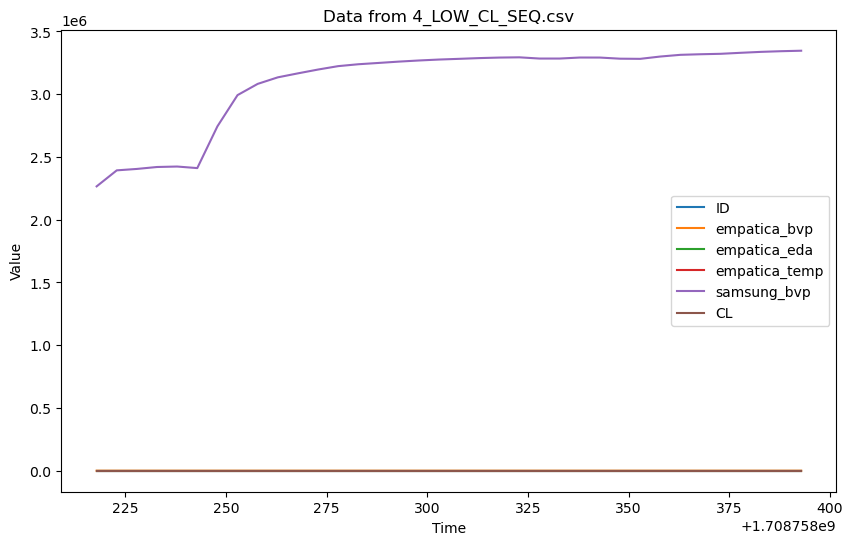

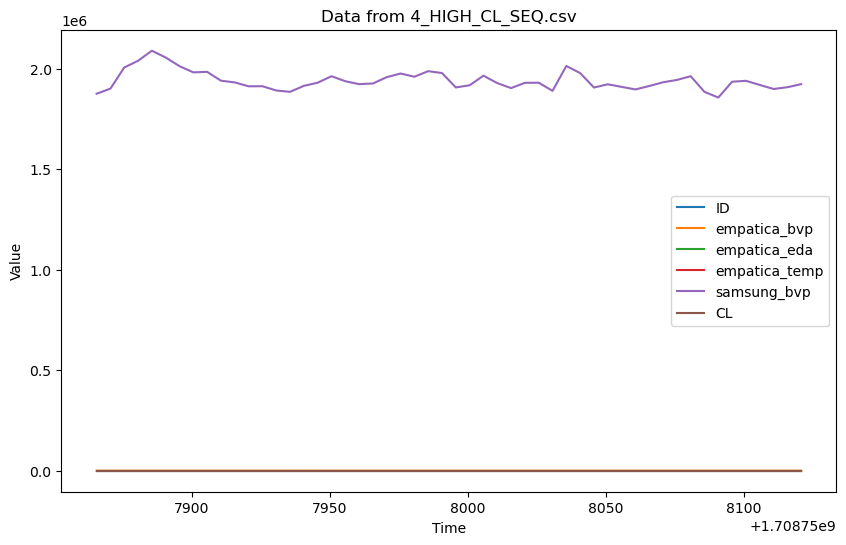

Error processing file ./data/participant-division/4/4_LOW_CL.csv: 'time'
Error processing file ./data/participant-division/4/4_HIGH_CL.csv: 'time'
Error processing file ./data/participant-division/3/3_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

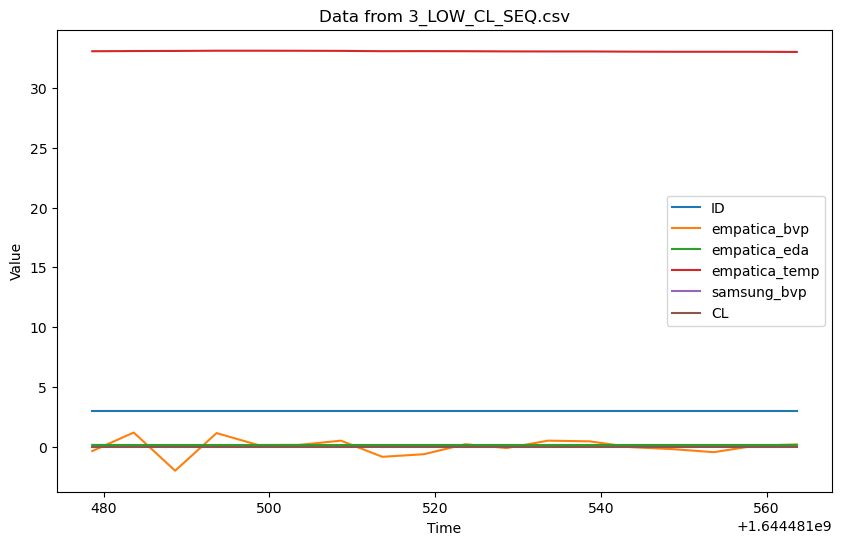

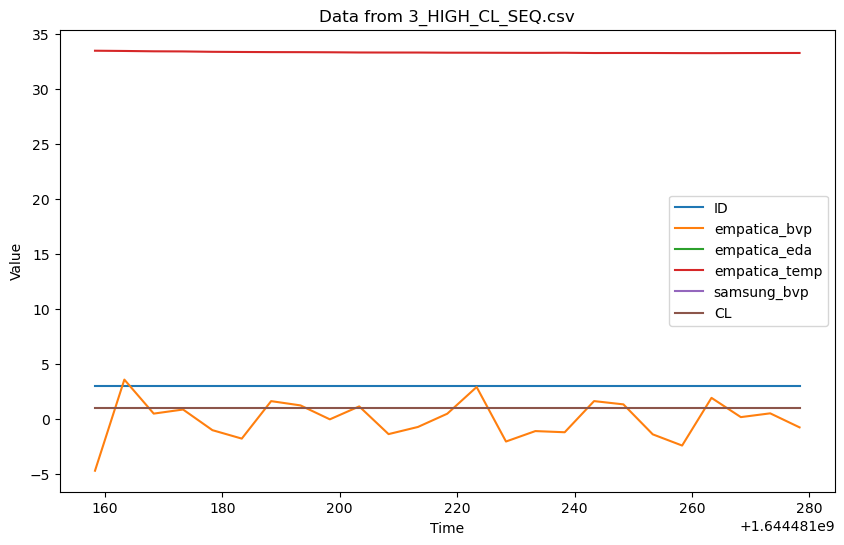

Error processing file ./data/participant-division/3/3_LOW_CL.csv: 'time'
Error processing file ./data/participant-division/2/2_LOW_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

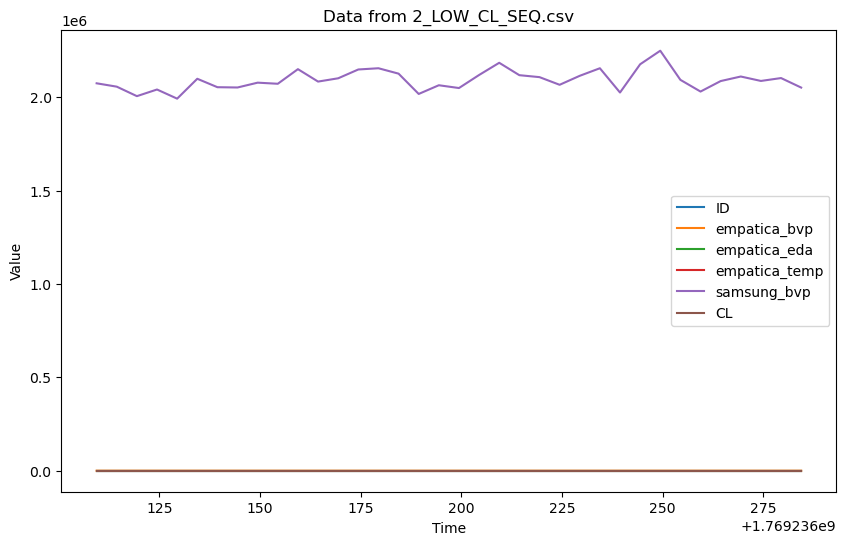

Error processing file ./data/participant-division/2/2_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

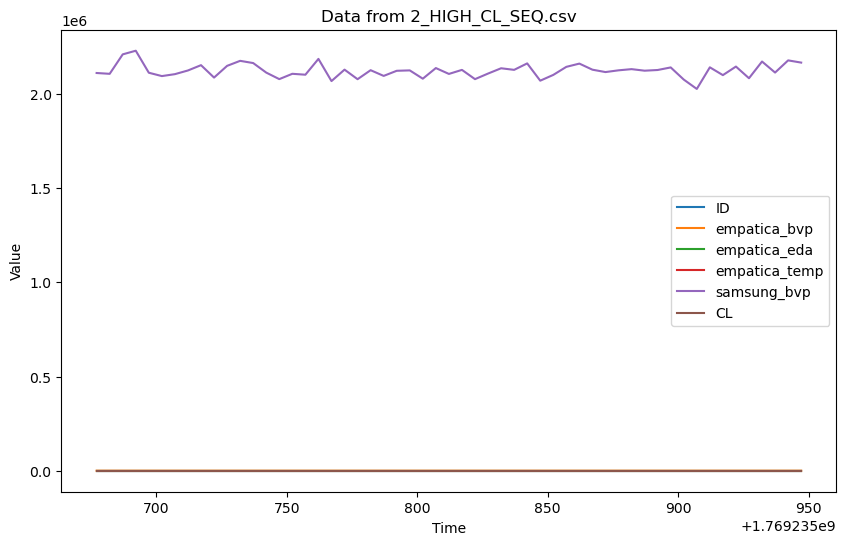

Error processing file ./data/participant-division/5/5_HIGH_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

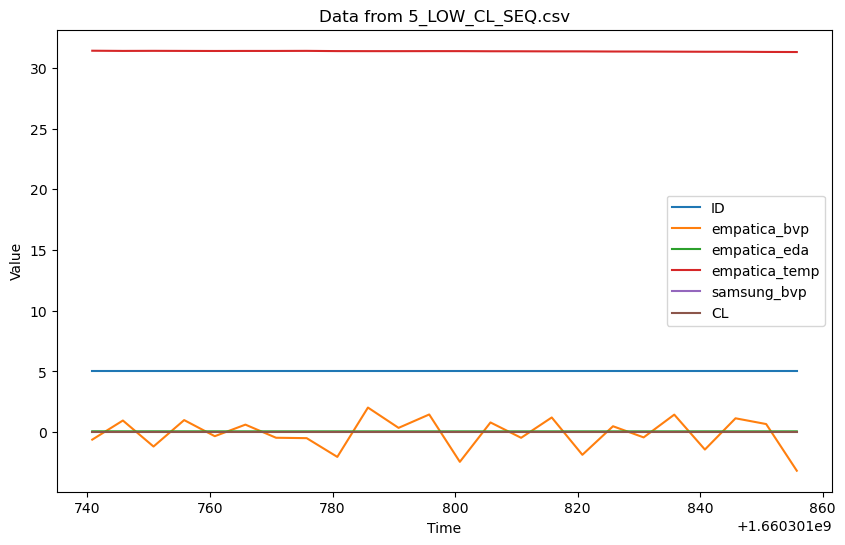

Error processing file ./data/participant-division/5/5_LOW_CL.csv: 'time'


<Figure size 1000x600 with 0 Axes>

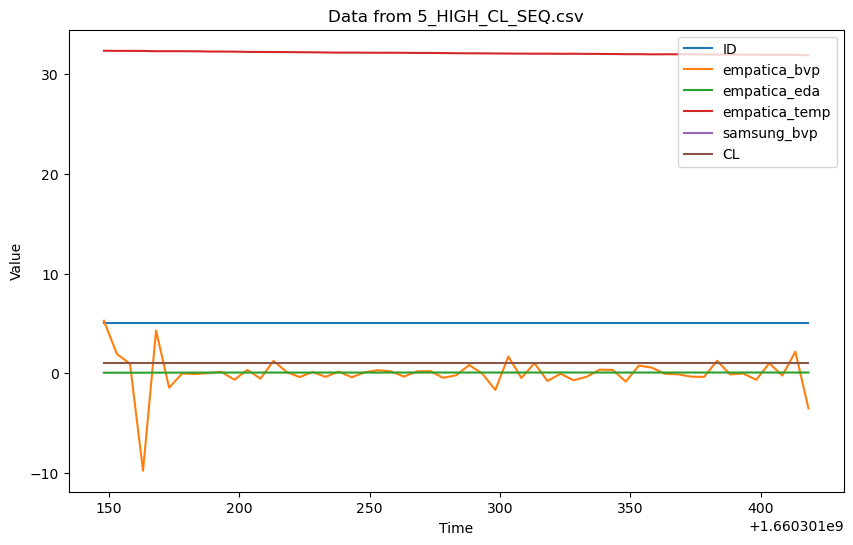

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def visualize_csv(csv_path):
    # Read CSV file
    df = pd.read_csv(csv_path)

    # Plot the data
    plt.figure(figsize=(10, 6))
    for column in df.columns:
        if column != "time":
            plt.plot(df["time"], df[column], label=column)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Data from {}".format(os.path.basename(csv_path)))
    plt.legend()
    plt.show()


def process_directory(root_dir):
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # if file.endswith(".csv") and (
            #     "0_high_cl_seq" in file.lower() or "1_high_cl_seq" in file.lower()
            # ):
            if file.endswith(".csv"):
                csv_path = os.path.join(subdir, file)
                try:
                    visualize_csv(csv_path)
                except Exception as e:
                    print(f"Error processing file {csv_path}: {e}")


if __name__ == "__main__":
    root_directory = "./data/participant-division"
    process_directory(root_directory)

## Dataset wearables physiological input aggregation

The aggregation process of Samsung and Empatica sourced records into the cogwear-agg.csv (output) file involves several key steps to ensure the proper structuring and representation of the data.

Firstly, each row extracted from the source CSV files undergoes a mapping process to transform its contents into a new row within the output file. During this mapping process, existing values are appropriately assigned to their corresponding columns in the output file. However, if any values are missing in the source records, the respective fields in the output file are left empty to maintain the integrity of the data structure.

The columns in the output file are defined as follows:

1. participant_id: Each participant's folder index is translated into a participant ID to uniquely identify the source of the data.
2. empatica_bvp: Represents the readings extracted from the Empatica device's Blood Volume Pulse (BVP) sensor.
3. empatica_bvp_time: Corresponds to the time records associated with the Empatica BVP readings.
4. empatica_eda: Denotes the readings obtained from the Empatica device's Electrodermal Activity (EDA) sensor.
5. empatica_eda_time: Reflects the time records corresponding to the Empatica EDA readings.
6. empatica_temp: Signifies the temperature readings captured by the Empatica device.
7. empatica_temp_time: Indicates the time records linked to the Empatica temperature readings.
8. samsung_bvp: Represents the readings collected from the Samsung device's Blood Volume Pulse (BVP) sensor.
9. samsung_bvp_time: Corresponds to the time records associated with the Samsung BVP readings.
10. CL: Stands for Cognitive Load and serves as a categorical indicator denoting the cognitive workload experienced during the data recording process. A value of 1 (high) indicates records sourced from the "cognitive_load" subdirectory, whereas a value of 0 (low) signifies records sourced from the "baseline" subdirectory.


In [2]:
import os
import pandas as pd


def process_directory(root_dir, output_file):
    # Create an empty list to store aggregated data
    agg_data = []

    # Iterate through the participant directories
    for participant_dir in os.listdir(root_dir):
        participant_id = (
            participant_dir  # Participant ID is the name of the subdirectory
        )

        # Iterate through the subdirectories (baseline and cognitive_load)
        for sub_dir in ["baseline", "cognitive_load"]:
            sub_dir_path = os.path.join(root_dir, participant_dir, sub_dir)

            # Check if the path is a directory
            if os.path.isdir(sub_dir_path):
                # Get the cognitive load label
                cl = 0 if sub_dir == "baseline" else 1

                # Iterate through the files in the subdirectory
                for file in os.listdir(sub_dir_path):
                    if file.endswith(".csv") and file.startswith(
                        ("empatica_bvp", "empatica_eda", "empatica_temp", "samsung_bvp")
                    ):
                        file_path = os.path.join(sub_dir_path, file)
                        df = pd.read_csv(file_path)
                        # Extract relevant data and append to the aggregated list
                        for _, row in df.iterrows():
                            agg_data.append(
                                {
                                    "participant_id": participant_id,
                                    "empatica_bvp": row.get("bvp"),
                                    "empatica_bvp_time": (
                                        row.get("time")
                                        if "empatica_bvp" in file
                                        else None
                                    ),
                                    "empatica_eda": row.get("eda"),
                                    "empatica_eda_time": (
                                        row.get("time")
                                        if "empatica_eda" in file
                                        else None
                                    ),
                                    "empatica_temp": row.get("temp"),
                                    "empatica_temp_time": (
                                        row.get("time")
                                        if "empatica_temp" in file
                                        else None
                                    ),
                                    "samsung_bvp": row.get("PPG GREEN"),
                                    "samsung_bvp_time": (
                                        row.get("time")
                                        if "samsung_bvp" in file
                                        else None
                                    ),
                                    "CL": cl,
                                }
                            )

    # Create a DataFrame from the aggregated data
    agg_df = pd.DataFrame(agg_data)

    # Write aggregated DataFrame to CSV file
    agg_df.to_csv(output_file, index=False)


if __name__ == "__main__":
    root_directory = "./data/cogwear/pilot"
    output_file = "./data/processed/cogwear-agg.csv"
    process_directory(root_directory, output_file)

## Time sequenced aggregation

**Objective:**

- Prepare the primary dataset for machine learning model training.

**Dataset Characteristics:**

- Records sourced from participants' use of Samsung and Empatica wearables.
- Variation in record frequency among sensors.

**Processing Strategy:**

- Interval Division: Divide records into 5-second intervals.
- Data Aggregation:
  - Calculate mean values for each column within each interval.
  - Result: Single record representing a 5-second interval with mean values.
- Labeling:
  - Assign appropriate labels (1 or 0) indicating cognitive load level.

**Outcome:**

- Uniform dataset suitable for training machine learning models.
- Each record corresponds to a 5-second interval with mean values and labels.


In [1]:
# import pandas as pd
# import numpy as np


# def aggregate_by_time(df):
#     # Create an empty list to store aggregated data
#     agg_data = []

#     # Iterate over each participant
#     # for participant_id in df["participant_id"].unique():
#     for participant_id in df["participant_id"].unique():
#         participant_df = df[df["participant_id"] == participant_id]

#         # Iterate over each time sequence
#         min_time = participant_df["empatica_bvp_time"].min()
#         max_time = participant_df["empatica_bvp_time"].max()
#         intervals = np.arange(min_time, max_time + 5, 5)

#         for interval_start, interval_end in zip(intervals[:-1], intervals[1:]):
#             interval_data = {"participant_id": participant_id}

#             for column in [
#                 "empatica_bvp",
#                 "empatica_eda",
#                 "empatica_temp",
#                 "samsung_bvp",
#             ]:
#                 interval_values = participant_df[
#                     (participant_df["empatica_bvp_time"] >= interval_start)
#                     & (participant_df["empatica_bvp_time"] < interval_end)
#                 ][column].tolist()
#                 if interval_values:
#                     interval_data[column] = interval_values
#                     interval_data[column + "_time"] = [interval_start] * len(
#                         interval_values
#                     )

#             if interval_data:  # Check if interval_data is not empty
#                 agg_data.append(interval_data)

#     # Create DataFrame from aggregated data
#     agg_df = pd.DataFrame(agg_data)
#     return agg_df


# if __name__ == "__main__":
#     # Read the existing cogwear-agg.csv
#     cogwear_df = pd.read_csv("./data/processed/cogwear-agg.csv")

#     # Aggregate the data by time sequences and participant IDs
#     aggregated_df = aggregate_by_time(cogwear_df)

#     # Write the aggregated data to a new CSV file
#     aggregated_df.to_csv("./data/processed/cogwear-agg-time-secv.csv", index=False)

In [3]:
import pandas as pd

# Read the dataset
df = pd.read_csv("./data/processed/cogwear-agg.csv")

# Separate the dataset based on CL categories
low_cl_df = df[df["CL"] == 0]
high_cl_df = df[df["CL"] == 1]

# Further split the dataset for each participant
low_cl_participant_dfs = {}
high_cl_participant_dfs = {}

# For the low cl, split the df against participants ids
for participant_id, participant_value_df in low_cl_df.groupby("participant_id"):
    # Create a new dictionary entry for each participant_id key
    low_cl_participant_dfs[participant_id] = participant_value_df

# For the high cl, split the df against participants ids
for participant_id, participant_value_df in high_cl_df.groupby("participant_id"):
    # Create a new dictionary entry for each participant_id key
    high_cl_participant_dfs[participant_id] = participant_value_df

# Save the low and high cognitive load datasets for each participant into separate directories / CSV files
for participant_id, df in low_cl_participant_dfs.items():
    df.to_csv(
        f"./data/participant-division/{participant_id}/{participant_id}_LOW_CL.csv",
        index=False,
    )
for participant_id, df in high_cl_participant_dfs.items():
    df.to_csv(
        f"./data/participant-division/{participant_id}/{participant_id}_HIGH_CL.csv",
        index=False,
    )

## Transform original records into new, time-sequenced records with 5-second intervals and mean values.

### Data Preparation:

- Read the original dataset containing sensor readings and cognitive load labels.
- Convert time columns to datetime objects for proper time handling.
- Sort the dataset by time columns to ensure sequential ordering.

### Define & Create Time Windows:

- Define the size of the time windows, typically set to 5 seconds.
- Combine time columns from all sensors to create a unified time column.
- Group the data into 5-second intervals using the combined time column.

### Process Each Time Window:

- Iterate over each 5-second interval.
- Calculate the mean values for sensor readings (bvp, eda, temp) within the interval.
- Calculate the upper limit of the time window to represent the end time of the interval.

### Generate New Records:

- For each interval, create a new record containing:
  - Participant ID: Identifies the participant associated with the record.
  - Mean sensor values: Calculated mean values for each sensor reading within the interval.
  - Time: Represents the upper limit of the time window, indicating the end time of the interval.
  - Cognitive Load (CL): Indicates the cognitive load level associated with the interval (0 for low, 1 for high).

### Aggregate New Records:

- Store the new records in a DataFrame or CSV file for further analysis or modeling.

### Repeat for Each Participant and Cognitive Load Level:

- Iterate through each participant's data and perform the above steps separately for low and high cognitive load sessions.

### Save Results:

- Save the processed data into separate files or databases for future use or analysis.


In [ ]:
# import os
# import pandas as pd


# # Function to process the data and create aggregated records
# def process_data(df, cl_type):
#     # # Convert time columns to datetime objects
#     # df["empatica_bvp_time"] = pd.to_datetime(df["empatica_bvp_time"], unit="s")
#     # df["empatica_eda_time"] = pd.to_datetime(df["empatica_eda_time"], unit="s")
#     # df["empatica_temp_time"] = pd.to_datetime(df["empatica_temp_time"], unit="s")
#     # df["samsung_bvp_time"] = pd.to_datetime(df["samsung_bvp_time"], unit="s")

#     # Sort the DataFrame by time columns
#     df.sort_values(
#         by=[
#             "empatica_bvp_time",
#             "empatica_eda_time",
#             "empatica_temp_time",
#             "samsung_bvp_time",
#         ],
#         inplace=True,
#     )

#     # Define the time window size (in seconds)
#     time_window_size = 5

#     # Create a combined time column representing the maximum of all time columns
#     df["time"] = df[
#         [
#             "empatica_bvp_time",
#             "empatica_eda_time",
#             "empatica_temp_time",
#             "samsung_bvp_time",
#         ]
#     ].max(axis=1)

#     # Group the data into 5-second intervals
#     grouped = df.groupby(pd.Grouper(key="time", freq=f"{time_window_size}S"))

#     # Create a new DataFrame to store the aggregated records
#     new_df = pd.DataFrame(
#         columns=[
#             "ID",
#             "empatica_bvp",
#             "empatica_eda",
#             "empatica_temp",
#             "samsung_bvp",
#             "time",
#             "CL",
#         ]
#     )

#     # Iterate over each 5-second interval
#     for time, group in grouped:
#         # Calculate the mean values for each column
#         mean_values = group.mean()

#         # Calculate the upper limit of the time window
#         time_upper_limit = time + pd.Timedelta(seconds=time_window_size)

#         # Append the mean values to the new DataFrame
#         new_df = new_df.append(
#             {
#                 "ID": mean_values["participant_id"],
#                 "empatica_bvp": mean_values["empatica_bvp"],
#                 "empatica_eda": mean_values["empatica_eda"],
#                 "empatica_temp": mean_values["empatica_temp"],
#                 "samsung_bvp": mean_values["samsung_bvp"],
#                 "time": time_upper_limit,
#                 "CL": cl_type,
#             },
#             ignore_index=True,
#         )

#     return new_df


# # Define the directory containing participant folders
# participant_directory = "./data/participant-division/"

# # Iterate through each participant folder
# for participant_id in os.listdir(participant_directory):
#     participant_folder = os.path.join(participant_directory, participant_id)

#     # Iterate through low and high cognitive load files
#     for cl_type in ["LOW_CL", "HIGH_CL"]:
#         input_filename = f"{participant_id}_{cl_type}.csv"
#         output_filename = f"{participant_id}_{cl_type}_SEQ.csv"

#         # Read the CSV file into a DataFrame
#         df = pd.read_csv(os.path.join(participant_folder, input_filename))

#         # Process the data and create aggregatLOWed records
#         new_df = process_data(df, 1 if cl_type == "HIGH_CL" else 0)

#         # Write the aggregated records to a new CSV file
#         new_df.to_csv(os.path.join(participant_folder, output_filename), index=False)

In [9]:
import os
import pandas as pd


# Function to process the data and create aggregated records
def process_data(df, cl_type):
    # Sort the DataFrame by time columns
    df.sort_values(
        by=[
            "empatica_bvp_time",
            "empatica_eda_time",
            "empatica_temp_time",
            "samsung_bvp_time",
        ],
        inplace=True,
    )

    # Define the time window size (in seconds)
    time_window_size = 5

    # Create a combined time column representing the maximum of all time columns
    df["time"] = df[
        [
            "empatica_bvp_time",
            "empatica_eda_time",
            "empatica_temp_time",
            "samsung_bvp_time",
        ]
    ].max(axis=1)

    # Determine the minimum and maximum time values
    min_time = df["time"].min()
    max_time = df["time"].max()

    # Calculate the number of time intervals
    # It is not accurate, because
    num_intervals = int((max_time - min_time) / time_window_size)

    # Create a list of time intervals using floating-point representation
    time_intervals = [
        min_time + i * time_window_size for i in range(num_intervals + 1)
    ]  # Include the last interval

    # Create a new DataFrame to store the aggregated records
    new_df = pd.DataFrame(
        columns=[
            "ID",
            "empatica_bvp",
            "empatica_eda",
            "empatica_temp",
            "samsung_bvp",
            "time",
            "CL",
        ]
    )

    # Iterate over each time interval
    for i in range(num_intervals):
        start_time = time_intervals[i]
        end_time = time_intervals[i + 1]

        # Select rows within the current time interval
        interval_rows = df[(df["time"] >= start_time) & (df["time"] < end_time)]

        # Calculate the mean values for each column within the time interval
        mean_values = interval_rows.mean()

        # Append the mean values to the new DataFrame
        new_df = new_df.append(
            {
                "ID": mean_values["participant_id"],
                "empatica_bvp": mean_values["empatica_bvp"],
                "empatica_eda": mean_values["empatica_eda"],
                "empatica_temp": mean_values["empatica_temp"],
                "samsung_bvp": mean_values["samsung_bvp"],
                "time": end_time,
                "CL": cl_type,
            },
            ignore_index=True,
        )

    return new_df


# Define the directory containing participant folders
participant_directory = "./data/participant-division/"

# Iterate through each participant folder
for participant_id in os.listdir(participant_directory):
    participant_folder = os.path.join(participant_directory, participant_id)

    # Iterate through low and high cognitive load files
    for cl_type in ["LOW_CL", "HIGH_CL"]:
        input_filename = f"{participant_id}_{cl_type}.csv"
        output_filename = f"{participant_id}_{cl_type}_SEQ.csv"

        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(participant_folder, input_filename))

        # Process the data and create aggregated records
        new_df = process_data(df, 1 if cl_type == "HIGH_CL" else 0)

        # Write the aggregated records to a new CSV file
        new_df.to_csv(os.path.join(participant_folder, output_filename), index=False)

/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/2815209949.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(
/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/2815209949.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(
/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/2815209949.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(
/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/2815209949.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(
/var/folders/xs/hb6fwm8j38qbb3z21p68

## Sequenced Datasets Aggregation

Organizing the aggregated data into separate files based on the cognitive load level (0 - LOW / 1 - HIGH)

- Write the aggregated records for each participant and cognitive load level to new CSV files.


In [10]:
import os
import pandas as pd

# Define the directory containing participant folders
participant_directory = "./data/participant-division/"

# Initialize DataFrames to store aggregated data for low and high cognitive load
low_cl_agg_df = pd.DataFrame()
high_cl_agg_df = pd.DataFrame()

# Iterate through each participant folder
for participant_id in os.listdir(participant_directory):
    participant_folder = os.path.join(participant_directory, participant_id)

    # Read the LOW_CL_SEQ.csv file into a DataFrame
    low_cl_seq_filename = f"{participant_id}_LOW_CL_SEQ.csv"
    low_cl_seq_path = os.path.join(participant_folder, low_cl_seq_filename)
    if os.path.exists(low_cl_seq_path):
        low_cl_seq_df = pd.read_csv(low_cl_seq_path)
        # Append to the low cognitive load aggregated DataFrame
        low_cl_agg_df = low_cl_agg_df.append(low_cl_seq_df, ignore_index=True)

    # Read the HIGH_CL_SEQ.csv file into a DataFrame
    high_cl_seq_filename = f"{participant_id}_HIGH_CL_SEQ.csv"
    high_cl_seq_path = os.path.join(participant_folder, high_cl_seq_filename)
    if os.path.exists(high_cl_seq_path):
        high_cl_seq_df = pd.read_csv(high_cl_seq_path)
        # Append to the high cognitive load aggregated DataFrame
        high_cl_agg_df = high_cl_agg_df.append(high_cl_seq_df, ignore_index=True)

# Save the aggregated data to new CSV files
low_cl_agg_df.to_csv("./data/high_low_separation/LOW_CL_AGG.csv", index=False)
high_cl_agg_df.to_csv("./data/high_low_separation/HIGH_CL_AGG.csv", index=False)

/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/4017371866.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  low_cl_agg_df = low_cl_agg_df.append(low_cl_seq_df, ignore_index=True)
/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/4017371866.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_cl_agg_df = high_cl_agg_df.append(high_cl_seq_df, ignore_index=True)
/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/4017371866.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  low_cl_agg_df = low_cl_agg_df.append(low_cl_seq_df, ignore_index=True)
/var/folders/xs/hb6fwm8j38qbb3z21p6821lw0000gn/T/ipykernel_7602/4017371866.py:29: FutureWarning: The frame.append method is deprecate

## Final Dataset Aggregation (!)

Create the final aggregated CSV dataset containing the processed data.


In [11]:
import pandas as pd

# Files path definition
high_cl_path = "./data/high_low_separation/HIGH_CL_AGG.csv"
low_cl_path = "./data/high_low_separation/LOW_CL_AGG.csv"
final_dataset_path = "./data/processed_dataset/cogwear_processed_dataset.csv"


def merge_high_low_cl_files(file1_path, file2_path, output_path):
    # Read the two CSV files into DataFrames
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # Merge the two DataFrames
    merged_df = pd.concat([df1, df2], ignore_index=True)

    # Write the merged DataFrame to a new CSV file
    merged_df.to_csv(output_path, index=False)
    print(f"Merged CSV file saved at {output_path}")


merge_high_low_cl_files(high_cl_path, low_cl_path, final_dataset_path)

Merged CSV file saved at ./data/processed_dataset/cogwear_processed_dataset.csv


## Dataset Filtering

The primary objective of this project is to compare the predictive capabilities of two physiological monitoring devices, Empatica and Samsung, in assessing cognitive load based on the physiological signals they capture.

### Argumentation for Discarding Rows with Missing Values:

- Ensuring the **consistency and reliability** of data is paramount in comparative analyses.
- To accurately evaluate the performance of the Empatica and Samsung devices in predicting cognitive load, it is relevant to compare their responses over identical time intervals, where both processed the same physiological signals inputs (**temporal alignment**).

  - Rows containing missing values indicate instances where one of the devices failed to capture physiological signals during a specific 5-second interval (**data completeness**).
  - By excluding rows with missing values, we mitigate potential biases that may arise from incomplete data, aiming for a balanced and unbiased comparison between the Empatica and Samsung devices (aiming for **unbiased dataset**).
  - The removal of incomplete records enhances the **statistical validity** of the analysis by focusing only on complete and comparable data points.

- **Data Quality** assurance:

  - Only complete and reliable data points are retained for subsequent analysis.

- **Comparative Analysis**:
  - Following data preprocessing, the comparative analysis between the Empatica and Samsung devices can be conducted with confidence, as both devices are evaluated based on a consistent and complete dataset.


In [12]:
import pandas as pd

# File paths
dataset_path = "./data/processed_dataset/cogwear_processed_dataset.csv"
filtered_dataset_path = "./data/processed_dataset/cgw_filtered_dataset.csv"

# Read the dataset
df = pd.read_csv(dataset_path)

# Drop rows with empty fields
df = df.dropna()

# Write the processed dataset to a new CSV file
df.to_csv(filtered_dataset_path, index=False)

print("Processed dataset saved at:", filtered_dataset_path)

Processed dataset saved at: ./data/processed_dataset/cgw_filtered_dataset.csv


## Dataset Balancing

In the context of exploring various classification machine learning algorithms architectures and models, achieving a balanced dataset with an equal number of samples for high and low cognitive load states is significant.

This **balanced dataset** ensures that the machine learning models are trained on a representative dataset that equally captures the characteristics of both cognitive load states.

By reducing any existing imbalance in the dataset, the models can learn to distinguish between high and low cognitive load states more effectively (**better efficiency**).

Balancing the dataset facilitates a fair comparison of different machine learning algorithms, allowing a **better assessment of their performance**.

Models trained on a balanced dataset are less likely to exhibit bias towards the majority class and are better equipped to perform well on unseen data. Additionally, a balanced dataset enhances the **robustness** and **reliability** of the classification models, enabling them to achieve higher accuracy and predictive performance across both high and low cognitive load states.

Ensuring equal number of samples for each cognitive load state, the performance of classification machine learning algorithms is enhanced and show more meaningful insights into cognitive load prediction.


In [25]:
# File paths
dataset_path = "./data/processed_dataset/cgw_filtered_dataset.csv"
balanced_dataset_path = "./data/dataset.csv"

# Read the dataset
df = pd.read_csv(dataset_path)

# Count the number of samples for each class
class_counts = df["CL"].value_counts()

# Determine which class has the smaller number of samples
minority_class = class_counts.idxmin()
minority_count = class_counts[minority_class]

# Calculate the difference in the number of samples between the two classes
majority_class = class_counts.idxmax()
majority_count = class_counts[majority_class]
difference = majority_count - minority_count

# Randomly select a subset of samples from the class with more samples
if difference > 0:
    majority_samples = df[df["CL"] == majority_class].sample(
        n=difference, random_state=11
    )

# Remove the selected subset from the class with more samples
df_balanced = df.drop(majority_samples.index)

# Fix number of digits for float columns
num_digits = 6

# Apply formatting to all float columns in the DataFrame except 'CL' and 'ID'
for column in df_balanced.select_dtypes(include=["float"]).columns:
    if column not in ["CL", "ID"]:
        df_balanced[column] = df_balanced[column].apply(lambda x: f"{x:.{num_digits}f}")

# Convert 'ID' and 'CL' columns to integer
df_balanced["ID"] = df_balanced["ID"].astype(int)
df_balanced["CL"] = df_balanced["CL"].astype(int)

# Save the balanced DataFrame to a new CSV file
df_balanced.to_csv(balanced_dataset_path, index=False)

## Dataset Relevant Column Filtering

The 'ID' and the 'time' columns are not relevant for training the Machine Learning models.
For this reason, the next step in the process of pre-processing the dataset is to discard them from the final form of the dataset before the processing -splitting, and further processing- steps.


In [27]:
import pandas as pd

# File path
dataset_path = "./data/dataset.csv"
reduced_dataset_path = "./data/reduced_dataset.csv"

# Read the dataset
df = pd.read_csv(dataset_path)

# Drop the 'time' and 'ID' columns
df_reduced = df.drop(columns=["time", "ID"])

# Save the reduced DataFrame to a new CSV file
df_reduced.to_csv(reduced_dataset_path, index=True)